In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('data/cleaned_data.csv', 
                   parse_dates=['Fully Paid','Approved']).drop(['Unnamed: 0'],axis=1)

In [4]:
# Select only the past 5 years of data to make sure the data is relevant
data = data[data['Fully Paid'] > '2014-05-15']

In [5]:
df_cat = pd.get_dummies(data[['Borough', 'Building Type', 'Efiling Filed',
        'Applicant Professional Title', 'Professional Cert']], drop_first = True)
df_cat['Duration'] = data['Duration']
df_cat = df_cat.rename(columns={'Building Type_OTHERS':'Building Type',
                                'Efiling Filed_Y':'Efiled',
                               'Applicant Professional Title_RA':'Pro Title',
                               'Professional Cert_Y':'Pro Certified'})
df_cat.head()

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Duration
0,0,0,1,0,0,1,1,0,158.0
3,0,0,1,0,0,1,1,1,87.0
4,1,0,0,0,1,1,1,0,193.0
5,0,0,0,1,0,1,1,0,234.0
6,1,0,0,0,1,1,1,0,89.0


In [6]:
# Create a combined dataframe with the columns to use for prediction
df_combined = pd.merge(df_cat, data[['Total Est. Fee',
    'Proposed Zoning Sqft', 'Proposed No. Of Stories']], left_index=True, right_index=True)
df_combined.head(2)

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Duration,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories
0,0,0,1,0,0,1,1,0,158.0,243.0,2700,2
3,0,0,1,0,0,1,1,1,87.0,100.0,300,1


#### Linear Regression - Multivariate

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [8]:
# Create the X and y for the regression
X = df_combined.drop('Duration', axis=1)
y = np.log(df_combined['Duration'].values.reshape(-1,1))

In [9]:
# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

# Create the regressor: reg
reg = LinearRegression()

# train the model
reg.fit(X_train, y_train)

# compute the real prediction on the test data
y_pred = reg.predict(X_test)

# Print R^2 
print("R^2 = {}".format(reg.score(X_test, y_test).round(3)))

R^2 = 0.386


In [10]:
# Cross-validate the results
# Import cross validation model.
from sklearn.model_selection import cross_val_score

In [11]:
# Obtain the R squared values by cross validation.
cv_results = cross_val_score(reg, X, y, cv=5)

# Get the mean value of the cross-validation results for R squared values.
mean_R2 = cv_results.mean().round(3)

print('Average 5-Fold cross-verification Score: {}'.format(mean_R2))

Average 5-Fold cross-verification Score: 0.325


#### Lasso Regression

* Helpful for feature selection. Identifies the most important variables.

In [12]:
from sklearn.linear_model import Lasso

In [13]:
# create the names of the variables
names = X.columns

# set the lasso variable
lasso = Lasso(alpha=0.1, normalize=True)
lasso_coef = lasso.fit(X,y).coef_
lasso_coef

array([ 0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.])

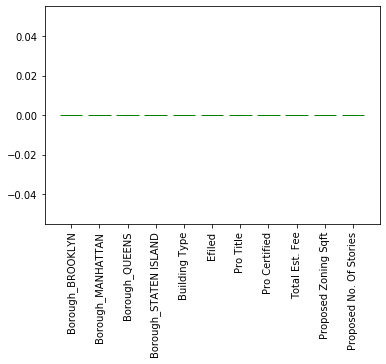

In [14]:
fig, ax = plt.subplots()
ax.bar(range(len(names)),lasso_coef)
ax.set_xticks(range(len(names)));
ax.set_xticklabels(names, rotation=90)
for i, v in enumerate(lasso_coef):
    if v < 0:
        ax.get_children()[i].set_color('red')
    else:
        ax.get_children()[i].set_color('green')

In [15]:
data['LogDur']= np.log(data['Duration'])

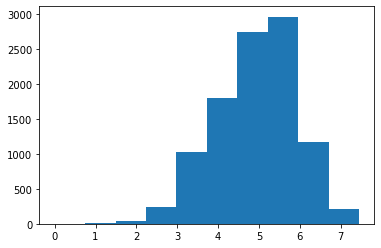

In [16]:
plt.hist(data['LogDur']);

#### Ridge Regression

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [18]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Instantiate the ridge regression and fit the train data
ridge = Ridge(normalize=True, alpha=0.1)
ridge.fit(X_train, y_train)
# predict the values
ridge_pred = ridge.predict(X_test)
# compute the R2: how much of the variance in the y is explained by the model. 
ridge.score(X_test, y_test)

0.35685331254716474

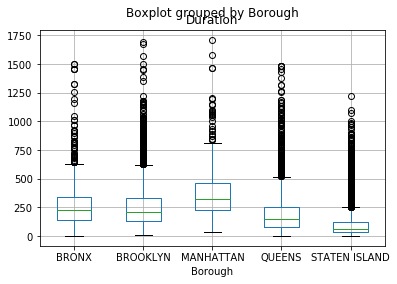

In [19]:
data.boxplot(column='Duration', by='Borough');

In [76]:
from sklearn.preprocessing import scale

In [77]:
data['Scaled_dur'] = scale(data['Duration'])

In [78]:
data

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Fully Paid,Approved,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,...,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration,Z_score,LogDur,Scaled_dur
0,QUEENS,1-2-3 FAMILY,Y,RA,N,2018-11-02,2019-04-09,243.00,2700,2,...,NaN,NaN,NaN,N,4050,NaN,158.0,-0.035313,5.062595,-0.260427
3,QUEENS,1-2-3 FAMILY,Y,RA,Y,2018-11-05,2019-01-31,100.00,300,1,...,NaN,NaN,NaN,N,300,NaN,87.0,-0.308763,4.465908,-0.612795
4,BROOKLYN,OTHERS,Y,RA,N,2014-06-14,2014-12-24,2209.84,5994,4,...,NaN,NaN,NaN,N,7884,2018-05-25,193.0,0.099486,5.262690,-0.086725
5,STATEN ISLAND,1-2-3 FAMILY,Y,RA,N,2015-01-23,2015-09-14,587.96,1245,3,...,NaN,NaN,NaN,N,2058,2018-05-25,234.0,0.257393,5.455321,0.116755
6,BROOKLYN,OTHERS,Y,RA,N,2015-03-25,2015-06-22,5082.32,15045,8,...,NaN,NaN,NaN,N,18932,NaN,89.0,-0.301060,4.488636,-0.602869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55840,STATEN ISLAND,1-2-3 FAMILY,Y,RA,N,2018-03-29,2018-05-11,100.00,650,1,...,NaN,SRD,NaN,N,650,NaN,43.0,-0.478224,3.761200,-0.831164
55841,STATEN ISLAND,1-2-3 FAMILY,Y,RA,Y,2018-03-29,2018-06-29,134.82,1498,2,...,NaN,HS,NaN,N,2247,NaN,92.0,-0.289506,4.521789,-0.587981
55842,BROOKLYN,OTHERS,Y,RA,N,2018-04-11,2019-05-30,1519.70,4339,4,...,NaN,NaN,NaN,N,5845,NaN,414.0,0.950645,6.025866,1.010082
55843,STATEN ISLAND,OTHERS,Y,RA,Y,2018-04-02,2018-07-26,1890.20,5271,3,...,NaN,NaN,NaN,N,7270,NaN,115.0,-0.200923,4.744932,-0.473833


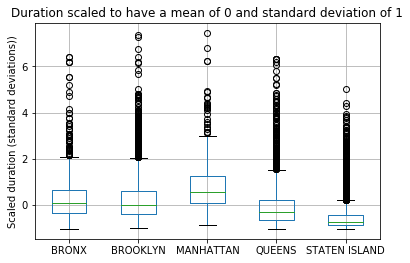

In [22]:
data.boxplot(column='Scaled_dur',by='Borough')
plt.suptitle('');
plt.xlabel('');
plt.ylabel('Scaled duration (standard deviations))');
plt.title('Duration scaled to have a mean of 0 and standard deviation of 1');

In [23]:
categor_cols = ['Borough', 'Building Type', 'Efiling Filed',
       'Applicant Professional Title', 'Professional Cert',
       'Proposed Occupancy', 'Zoning Dist1', 'Zoning Dist2', 'Zoning Dist3',
       'Special District 1', 'Special District 2', 'Non-Profit']

In [24]:
df_cat = data[categor_cols]

In [107]:
from sklearn.cluster import KMeans

In [104]:
from sklearn.impute import SimpleImputer

In [101]:
from sklearn.pipeline import Pipeline

In [92]:
klass = data[['Borough', 'Building Type', 'Efiling Filed',
       'Applicant Professional Title', 'Professional Cert',
       'Total Est. Fee', 'Proposed Zoning Sqft',
       'Proposed No. Of Stories', 'Proposed Height', 'Proposed Dwelling Units',
       'Proposed Occupancy']]

In [95]:
klass.head()

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,Proposed Height,Proposed Dwelling Units,Proposed Occupancy
0,QUEENS,1-2-3 FAMILY,Y,RA,N,243.00,2700,2,28,2.0,R-3
3,QUEENS,1-2-3 FAMILY,Y,RA,Y,100.00,300,1,12,NaN,U
4,BROOKLYN,OTHERS,Y,RA,N,2209.84,5994,4,50,8.0,R-2
5,STATEN ISLAND,1-2-3 FAMILY,Y,RA,N,587.96,1245,3,37,1.0,R-3
6,BROOKLYN,OTHERS,Y,RA,N,5082.32,15045,8,80,16.0,R-2


In [127]:
kmeans = KMeans(n_clusters=5)

In [129]:
imp = SimpleImputer()

In [154]:
def impute_values(df,strategy):
    df = df
    imp = SimpleImputer(strategy=strategy)
    for column in df.columns:
        df.loc[:,column] = imp.fit_transform(df[[column]])
    return df

In [171]:
new_klass.shape

(10242, 11)

In [131]:
imp.fit(klass[['Proposed No. Of Stories']])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [172]:
pipeline = Pipeline([('imputer',SimpleImputer),
                      ('kmeans', KMeans(n_clusters=5))
                    ])

In [178]:
X = klass[['Proposed No. Of Stories','Proposed Zoning Sqft']]

In [180]:
clusters = kmeans.fit_predict(X)

In [192]:
X['Clusters'] = clusters
X['Borough'] = klass['Borough']

/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [196]:
klass['Clusters'] = clusters

/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [200]:
klass.head()

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,Proposed Height,Proposed Dwelling Units,Proposed Occupancy,Clusters
0,QUEENS,1-2-3 FAMILY,Y,RA,N,243.00,2700,2,28,2.0,R-3,3
3,QUEENS,1-2-3 FAMILY,Y,RA,Y,100.00,300,1,12,1.0,U,3
4,BROOKLYN,OTHERS,Y,RA,N,2209.84,5994,4,50,8.0,R-2,3
5,STATEN ISLAND,1-2-3 FAMILY,Y,RA,N,587.96,1245,3,37,1.0,R-3,3
6,BROOKLYN,OTHERS,Y,RA,N,5082.32,15045,8,80,16.0,R-2,3


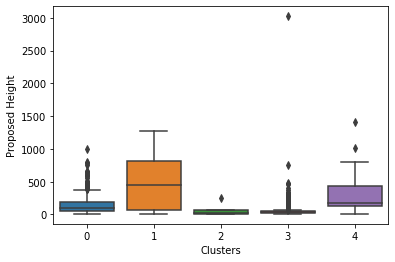

In [206]:
sns.boxplot(data=klass, x='Clusters', y='Proposed Height')

In [123]:
klass[['Total Est. Fee','Proposed Zoning Sqft']].values

array([[ 243.  , 2700.  ],
       [ 100.  ,  300.  ],
       [2209.84, 5994.  ],
       ...,
       [1519.7 , 4339.  ],
       [1890.2 , 5271.  ],
       [2283.84, 7215.  ]])

In [226]:
feature_values = np.array([[2, 1]])
components = np.array([[1., 0.5, 0.],[0.2,0.1,2.1]])

In [229]:
np.dot(feature_values, components)

array([[2.2, 1.1, 2.1]])